## This notebook applies four filtering techniques to the MIMIC-IV raw dataset, generating four filtered datasets.
It evaluates the best preprocessing method using LSTM and U-Net base models with cross-validation.

In [ ]:
import wfdb
from scipy.io import savemat
import scipy.io as sio
import matplotlib.pyplot as plt
import scipy.signal as sp
from scipy import signal
import neurokit2 as nk
import numpy as np
import pywt

In [ ]:
data = sio.loadmat('MIMIC-IV_raw.mat')
print(data['1'][0, 0])

(array([[ nan,  nan,  nan, ..., 72.5, 72.5, 72.5]]), array([[ 0.   ,  0.005,  0.015, ..., -0.015, -0.015,  0.   ]]), array([[0.50292969, 0.50292969, 0.50292969, ..., 0.57495117, 0.57080078,
        0.56225586]]))


### The functions below apply initial filtering, which:
    - remove Nan values from signals
    - ECG range [-6, 6] - remove outliers from ECG
    - ABP range [60, 180] - remove outliers 2

In [ ]:
def split_signal(signal, duration=10, fs=62.5):
    fragment_length = int(duration * fs)
    return [signal[i:i + fragment_length] for i in range(0, len(signal), fragment_length)]


def initial_filter(ecg_fragments, abp_fragments, ppg_fragments):
    filtered_ecg, filtered_abp, filtered_ppg, removed_indices = [], [], [], []
    for i, (ecg, abp, ppg) in enumerate(zip(ecg_fragments, abp_fragments, ppg_fragments)):
        if (np.isnan(ecg).any() or np.isnan(abp).any() or np.isnan(ppg).any() or
                (ecg < -6).any() or (ecg > 6).any() or
                (abp < 60).any() or (abp > 180).any()):
            removed_indices.append(i)
        else:
            filtered_ecg.append(ecg)
            filtered_abp.append(abp)
            filtered_ppg.append(ppg)
    return filtered_ecg, filtered_abp, filtered_ppg, removed_indices

In [ ]:
# Initialize structures to store filtered records
filtered_data = {}  # Dictionary to hold filtered ECG and ABP for each record

# Initialize variables to track total lengths
total_length_before_filter = 0
total_length_after_filter = 0
c = 1

# Loop through each record
for record_id in range(1, 53):  # Adjust range if needed
    print(f"Processing record {record_id}")
    M = data[str(record_id)][0, 0]  # Access each record by its ID

    # Extract the signals
    abp = M['abp'].flatten()  # Flatten if stored as a 2D array
    ecg = M['ecg'].flatten()
    ppg = M['ppg'].flatten()

    # Split the signals into episodes
    abp_episodes = split_signal(abp)
    ecg_episodes = split_signal(ecg)
    ppg_episodes = split_signal(ppg)

    #print(f"PPG: {len(ppg_episodes)} and inside {len(ppg_episodes[0])}")

    # Update the total length before filtering
    total_length_before_filter += len(abp_episodes)

    # Apply filtering
    ecg_filt1, abp_filt1, ppg_filt1, _ = initial_filter(ecg_episodes, abp_episodes, ppg_episodes)

    # Update the total length after filtering
    total_length_after_filter += len(abp_filt1)

    if len(abp_filt1) > 0:
        filtered_data[c] = {
            'filtered_ecg': ecg_filt1,
            'filtered_abp': abp_filt1,
            'filtered_ppg': ppg_filt1
        }
        c += 1

# Print the results
print(f"Total length of ABP episodes before filtering: {total_length_before_filter}")
print(f"Total length of ABP episodes after filtering: {total_length_after_filter}")

Processing record 1
Processing record 2
Processing record 3
Processing record 4
Processing record 5
Processing record 6
Processing record 7
Processing record 8
Processing record 9
Processing record 10
Processing record 11
Processing record 12
Processing record 13
Processing record 14
Processing record 15
Processing record 16
Processing record 17
Processing record 18
Processing record 19
Processing record 20
Processing record 21
Processing record 22
Processing record 23
Processing record 24
Processing record 25
Processing record 26
Processing record 27
Processing record 28
Processing record 29
Processing record 30
Processing record 31
Processing record 32
Processing record 33
Processing record 34
Processing record 35
Processing record 36
Processing record 37
Processing record 38
Processing record 39
Processing record 40
Processing record 41
Processing record 42
Processing record 43
Processing record 44
Processing record 45
Processing record 46
Processing record 47
Processing record 48
P

In [ ]:
print(f"The number of filtered records is {len(filtered_data)} out of 52 initial")

The number of filtered records is 44 out of 52 initial


In [ ]:
# Loop through filtered ABP data to check if any value is < 60 or > 180
invalid_abp_indices = []

# Iterate through all entries in filtered_data
for c, data_item in filtered_data.items():  # Assuming filtered_data is a dictionary
    for i, abp in enumerate(data_item['filtered_abp']):
        if np.any(abp < 60) or np.any(abp > 180):  # Check if any value is out of range
            invalid_abp_indices.append((c, i))  # Store both the episode (c) and the index (i)

# Print the indices of invalid episodes
print("Invalid ABP indices:", invalid_abp_indices)



Invalid ABP indices: []


## Analysis of Raw MIMIC-IV Data
### Mean SBP and DBP of records and their duration

In [ ]:
import numpy as np
from scipy.signal import find_peaks

# Initialize results dictionary
results = {}

# Loop through all records
for record_id in range(1, 53):  # Adjust range if necessary
    # Extract ABP signal for the record
    M = data[str(record_id)][0, 0]  # Access each record
    abp = M['abp'].flatten()  # Flatten if necessary

    # Find systolic (peaks) and diastolic (valleys) points
    sbp_indices, _ = find_peaks(abp)  # Peaks are SBP
    dbp_indices, _ = find_peaks(-abp)  # Valleys are DBP

    # Extract SBP and DBP values
    sbp_values = abp[sbp_indices]
    dbp_values = abp[dbp_indices]

    # Calculate mean SBP and DBP
    mean_sbp = np.mean(sbp_values) if len(sbp_values) > 0 else np.nan
    mean_dbp = np.mean(dbp_values) if len(dbp_values) > 0 else np.nan

    # Calculate duration (in seconds)
    duration = len(abp) / 62.5  # Total samples divided by frequency

    # Store results for the current record
    results[record_id] = {
        'mean_sbp': mean_sbp,
        'mean_dbp': mean_dbp,
        'duration_minutes': duration / 60
    }

# Display the results
for record_id, stats in results.items():
    print(f"Record {record_id}:")
    print(f"  Mean SBP: {stats['mean_sbp']:.2f} mmHg")
    print(f"  Mean DBP: {stats['mean_dbp']:.2f} mmHg")
    print(f"  Duration: {stats['duration_minutes']:.2f} minutes")
    print()


Record 1:
  Mean SBP: 27.77 mmHg
  Mean DBP: 27.08 mmHg
  Duration: 52.39 minutes

Record 2:
  Mean SBP: 104.34 mmHg
  Mean DBP: 46.47 mmHg
  Duration: 42.15 minutes

Record 3:
  Mean SBP: 87.70 mmHg
  Mean DBP: 61.15 mmHg
  Duration: 196.78 minutes

Record 4:
  Mean SBP: 85.14 mmHg
  Mean DBP: 59.06 mmHg
  Duration: 424.19 minutes

Record 5:
  Mean SBP: 82.72 mmHg
  Mean DBP: 59.47 mmHg
  Duration: 14.42 minutes

Record 6:
  Mean SBP: 84.18 mmHg
  Mean DBP: 46.70 mmHg
  Duration: 1384.28 minutes

Record 7:
  Mean SBP: 104.62 mmHg
  Mean DBP: 77.06 mmHg
  Duration: 469.85 minutes

Record 8:
  Mean SBP: 80.00 mmHg
  Mean DBP: 57.78 mmHg
  Duration: 142.93 minutes

Record 9:
  Mean SBP: 101.44 mmHg
  Mean DBP: 73.56 mmHg
  Duration: 112.47 minutes

Record 10:
  Mean SBP: 96.55 mmHg
  Mean DBP: 66.71 mmHg
  Duration: 114.43 minutes

Record 11:
  Mean SBP: 18.31 mmHg
  Mean DBP: 17.96 mmHg
  Duration: 11.01 minutes

Record 12:
  Mean SBP: 112.58 mmHg
  Mean DBP: 96.23 mmHg
  Duration: 281.

### Preprocessing functions for Raw Data Pipeline:
- Step 1: Upsample all signals to 1000 Hz
- Step 2: Apply filters:
    For now we consider 4 filters:
    - Bandpass filter + MAF: for PPG (as in TransfoRhythm paper), for ECG with params suggested by Wuerich
    - Bandpass filter without MAF
    - Discrete Wavelet Transform: same for PPG and ECG, suggested by Kachuee
    - Neurokit2 package ecg.clean(), which is butterworth filter + powerline; and for ppg - ppg.clean()
- Step 3: Downsample signals to original rate of 62.5 Hz



In [ ]:
def resample_signal(signal_data, original_freq = 62.5, target_freq = 1000):
    num_samples = int(len(signal_data) * target_freq / original_freq)
    resampled_signal = signal.resample(signal_data, num_samples)
    return resampled_signal


# Referred to Wuerich paper solo ECG, no MAF
def butterworth_filter_ecg(ecg_signal, lowcut=0.3, highcut=60, fs=1000, order=5):

    # Design the Butterworth bandpass filter
    sos = sp.butter(order, [lowcut, highcut], fs=fs, btype='bandpass', output='sos')
    ecg_filtered = sp.sosfilt(sos, ecg_signal)

    return ecg_filtered

# Only Butterworth filter
## The params were choosen referring TransfoRhythm Paper. Except for order, as order=5 shifted phase significantly
def butterworth_filter_ppg(ppg_signal, lowcut=0.3, highcut=5, fs=1000, order=3):
    # Step 1: Design and apply the Butterworth bandpass filter
    sos = sp.butter(order, [lowcut, highcut], fs=fs, btype='bandpass', output='sos')
    ppg_filtered = sp.sosfilt(sos, ppg_signal)

    # Step 2: Restore the signal to its original mean
    original_mean = np.mean(ppg_signal)
    ppg_final = ppg_filtered + (original_mean - np.mean(ppg_filtered))

    return ppg_final

# Butterworth filter + MAF
## The params were choosen referring TransfoRhythm Paper. Except for order, as order=5 shifted phase significantly
### For MAF window size reffered: 25% of episode (625 data points)
# https://medium.com/@thedatabeast/time-series-part-4-determining-the-window-size-for-moving-averages-a07c5cfcfac9#:~:text=Rule%20of%20thumb%3A%20A%20commonly,data%20points%20might%20be%20appropriate.
def butterworth_maf_ppg(ppg_signal, lowcut=0.3, highcut=5, fs=1000, order=3):

    # Step 1: Design and apply the Butterworth bandpass filter
    sos = sp.butter(order, [lowcut, highcut], fs=fs, btype='bandpass', output='sos')
    ppg_filtered = sp.sosfilt(sos, ppg_signal)

    # Step 2: Apply a 5th-order moving average filter
    window_size = 157  # Moving average filter order
    moving_avg_filter = np.ones(window_size) / window_size  # Create the filter
    ppg_smoothed = np.convolve(ppg_filtered, moving_avg_filter, mode='same')  # Apply moving average

    # Step 3: Restore the signal to its original mean
    original_mean = np.mean(ppg_signal)
    ppg_final = ppg_smoothed + (original_mean - np.mean(ppg_smoothed))

    return ppg_final

# Referred to Wuerich paper solo ECG, + MAF
def butterworth_maf_ecg(ecg_signal, lowcut=0.3, highcut=60, fs=1000, order=5):

    # Step 1: Design the Butterworth bandpass filter
    sos = sp.butter(order, [lowcut, highcut], fs=fs, btype='bandpass', output='sos')
    ecg_filtered = sp.sosfilt(sos, ecg_signal)

    # Step 2: Apply a 5th-order moving average filter
    window_size = 5  # Moving average filter order
    moving_avg_filter = np.ones(window_size) / window_size  # Create the filter
    ecg_smoothed = np.convolve(ecg_filtered, moving_avg_filter, mode='same')  # Apply moving average

    return ecg_smoothed


# Refered to Kachuee paper
def dwt_filter(ppg_signal, ecg_signal):
    levels = 9
    wavelet_function = 'db8'
    fs = 1000

    # Store the original mean of the PPG signal
    ppg_original_mean = np.mean(ppg_signal)
    ecg_original_mean = np.mean(ecg_signal)

    # Remove the mean to center the signal
    ppg_signal_centered = ppg_signal - ppg_original_mean
    ecg_signal_centered = ecg_signal - ecg_original_mean

    # Function to decompose, filter, and reconstruct the signal
    def wavelet_filter_and_reconstruct(signal, wavelet_function, levels, fs):
        # Decompose the signal using DWT
        coeffs = pywt.wavedec(signal, wavelet_function, level=levels)
        freq_band = fs / (2 ** np.arange(levels + 1, 1, -1))  # Frequency range for each level

        # Zero out unwanted frequencies
        for i, c in enumerate(coeffs):
            f_min = 0 if i == 0 else freq_band[i - 1]
            f_max = freq_band[i] if i < levels else np.inf

            if f_min < 0.25 or f_max > 250:  # Remove low (<0.25Hz) and high (>250Hz) frequencies
                coeffs[i] = np.zeros_like(c)  # Zero out coefficients for unwanted frequencies

        # Reconstruct the signal using the modified (filtered) coefficients
        filtered_signal = pywt.waverec(coeffs, wavelet_function)
        return filtered_signal

    # Apply the wavelet filter to PPG and ECG
    ppg_filtered = wavelet_filter_and_reconstruct(ppg_signal_centered, wavelet_function, levels, fs)
    ecg_filtered = wavelet_filter_and_reconstruct(ecg_signal_centered, wavelet_function, levels, fs)

    # Restore the original mean of the signals
    ppg_filtered += ppg_original_mean
    ecg_filtered += ecg_original_mean

    return ppg_filtered, ecg_filtered


def neurokit_filter(ppg_signal, ecg_signal):
    fs = 1000  # Sampling frequency

    # Compute the original mean of the PPG signal
    ppg_original_mean = np.mean(ppg_signal)

    # Filter signals using NeuroKit's cleaning methods
    ecg_filtered = nk.ecg_clean(ecg_signal, sampling_rate=fs, method="neurokit")
    ppg_filtered = nk.ppg_clean(ppg_signal, sampling_rate=fs, method="elgendi")

    # Return PPG signal to its original mean
    ppg_filtered += ppg_original_mean

    return ppg_filtered, ecg_filtered

from scipy.signal import decimate

def downsample_to_original_rate(signal, original_fs=62.5, current_fs=1000):
    """
    Downsamples filtered PPG, ABP, and ECG signals back to the original sampling rate.

    Parameters:
        ppg_filt_segment (array): Filtered PPG signal at higher sampling rate.
        ecg_filt_segment (array): Filtered ECG signal at higher sampling rate.
        original_fs (float): Target sampling rate (default: 62.5 Hz).
        current_fs (float): Current sampling rate (default: 1000 Hz).

    Returns:
        tuple: Downsampled PPG, ABP, and ECG signals.
    """
    decimation_factor = int(current_fs / original_fs)

    # Decimate the filtered signals
    signal_downsampled = decimate(signal, decimation_factor, zero_phase=True)

    return signal_downsampled


def maf_filter_abp(abp_signal, window_size=5):
    """
    Applies a Moving Average Filter (MAF) to the ABP signal with minimal impact on SBP and DBP.

    Parameters:
        abp_signal (array): Input ABP signal.
        window_size (int): Size of the moving average filter window (default=5).

    Returns:
        array: Smoothed ABP signal with minimal impact on SBP and DBP values.
    """
    # Step 1: Reflect padding for smoother edges
    pad_size = window_size // 2
    padded_signal = np.pad(abp_signal, pad_size, mode='reflect')

    # Step 2: Apply the moving average filter
    moving_avg_filter = np.ones(window_size) / window_size
    smoothed_signal = np.convolve(padded_signal, moving_avg_filter, mode='valid')  # 'valid' avoids padding artifacts

    # Step 3: Ensure SBP and DBP values remain intact
    sbp_original = np.max(abp_signal)
    dbp_original = np.min(abp_signal)

    sbp_smoothed = np.max(smoothed_signal)
    dbp_smoothed = np.min(smoothed_signal)

    # Restore original SBP and DBP values
    smoothed_signal[np.argmax(smoothed_signal)] = sbp_original
    smoothed_signal[np.argmin(smoothed_signal)] = dbp_original

    return smoothed_signal



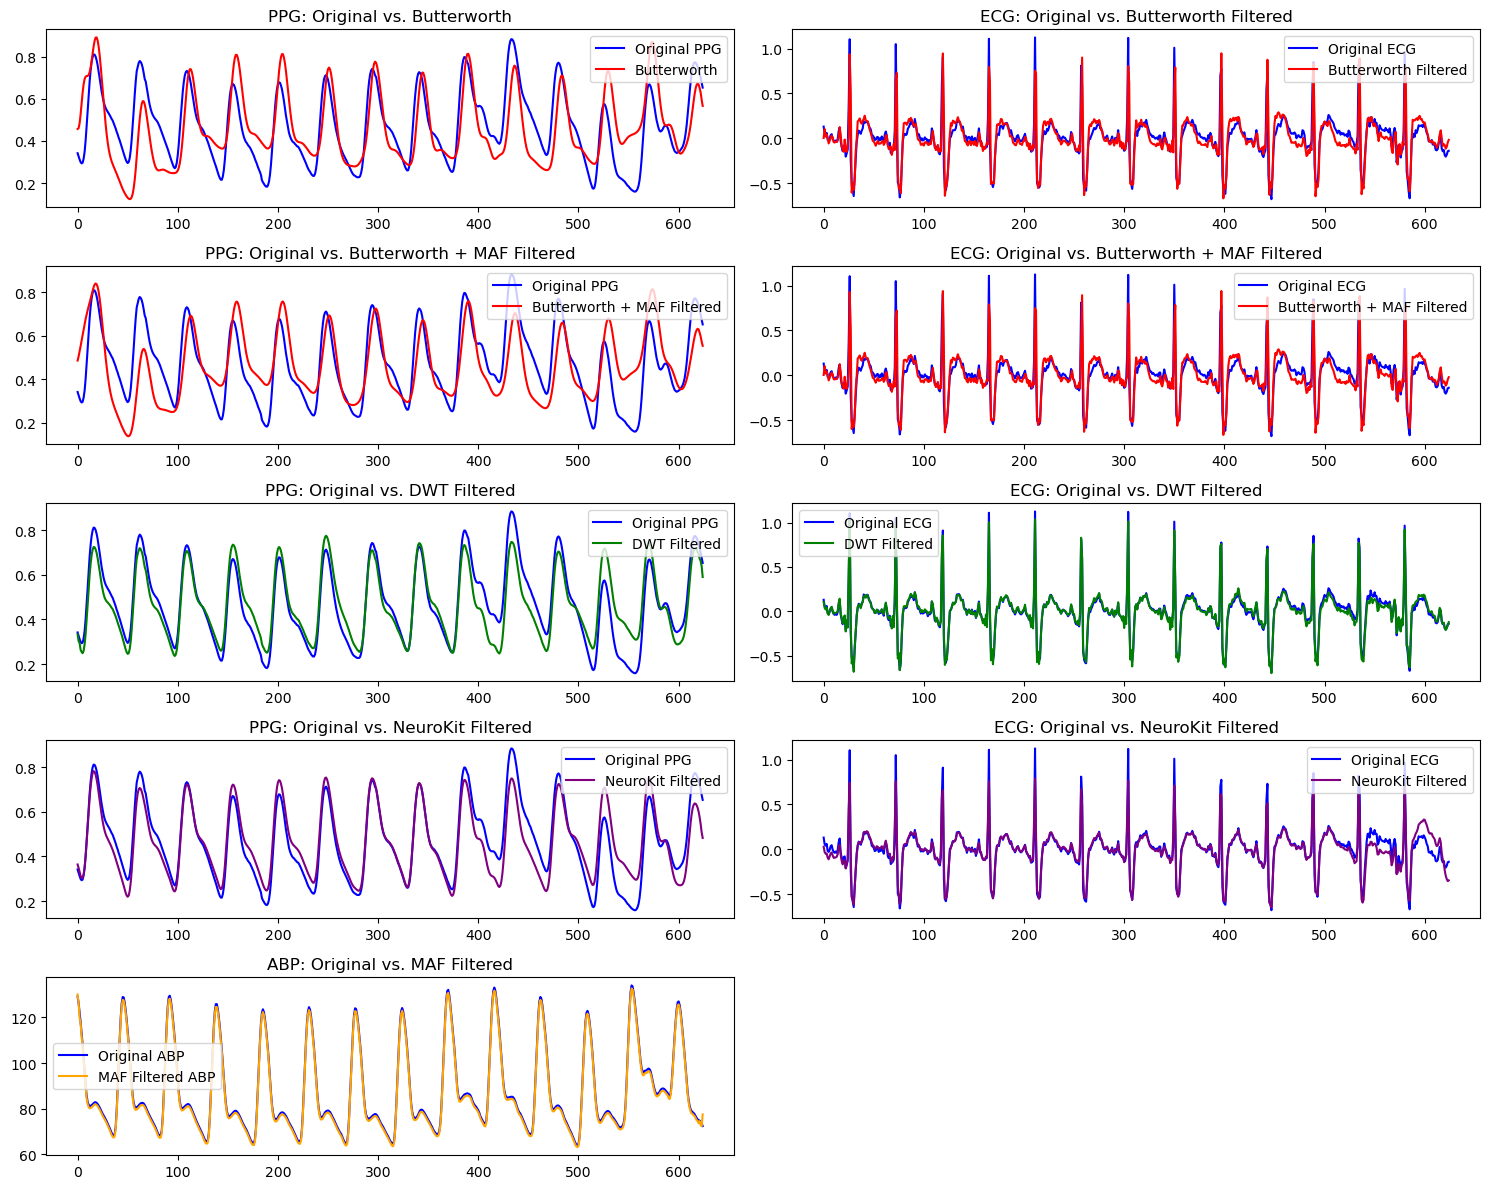

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Choose a subject and segment (adjust indices as necessary)
i = 16  # Subject ID
j = 1  # Episode index

# Extract filtered ECG, PPG, and ABP signals from the data structure
ppg_segment = filtered_data[i]['filtered_ppg'][j]
ecg_segment = filtered_data[i]['filtered_ecg'][j]
abp_segment = filtered_data[i]['filtered_abp'][j]  # Extract ABP signal

# Resample the signals
ppg_resampled = resample_signal(ppg_segment)
ecg_resampled = resample_signal(ecg_segment)
abp_resampled = resample_signal(abp_segment)

# Apply Butterworth filter
ppg_butter_filtered = butterworth_filter_ppg(ppg_resampled)
ecg_butter_filtered = butterworth_filter_ecg(ecg_resampled)

# Apply Butterworth filter + MAF
ppg_butter_maf_filtered = butterworth_maf_ppg(ppg_resampled)
ecg_butter_maf_filtered = butterworth_maf_ecg(ecg_resampled)

# Apply DWT filter
ppg_dwt_filtered, ecg_dwt_filtered = dwt_filter(ppg_resampled, ecg_resampled)

# Apply NeuroKit filter
ppg_neurokit_filtered, ecg_neurokit_filtered = neurokit_filter(ppg_resampled, ecg_resampled)

# Apply MAF filter to ABP
abp_filtered = maf_filter_abp(abp_resampled)

# Downsample the filtered signals back to the original rate
ppg_but_down = downsample_to_original_rate(ppg_butter_filtered)
ecg_but_down = downsample_to_original_rate(ecg_butter_filtered)

ppg_but_maf_down = downsample_to_original_rate(ppg_butter_maf_filtered)
ecg_but_maf_down = downsample_to_original_rate(ecg_butter_maf_filtered)

ppg_dwt_down = downsample_to_original_rate(ppg_dwt_filtered)
ecg_dwt_down = downsample_to_original_rate(ecg_dwt_filtered)

ppg_nk_down = downsample_to_original_rate(ppg_neurokit_filtered)
ecg_nk_down = downsample_to_original_rate(ecg_neurokit_filtered)

abp_down = downsample_to_original_rate(abp_filtered)  # Downsample ABP

# Plot original vs. filtered signals
fig, axes = plt.subplots(5, 2, figsize=(15, 12))

# Original vs. Butterworth filtered
axes[0, 0].plot(ppg_segment, label='Original PPG', color='blue')
axes[0, 0].plot(ppg_but_down, label='Butterworth', color='red')
axes[0, 0].set_title('PPG: Original vs. Butterworth')
axes[0, 0].legend()

axes[0, 1].plot(ecg_segment, label='Original ECG', color='blue')
axes[0, 1].plot(ecg_but_down, label='Butterworth Filtered', color='red')
axes[0, 1].set_title('ECG: Original vs. Butterworth Filtered')
axes[0, 1].legend()

# Original vs. Butterworth + MAF filtered
axes[1, 0].plot(ppg_segment, label='Original PPG', color='blue')
axes[1, 0].plot(ppg_but_maf_down, label='Butterworth + MAF Filtered', color='red')
axes[1, 0].set_title('PPG: Original vs. Butterworth + MAF Filtered')
axes[1, 0].legend()

axes[1, 1].plot(ecg_segment, label='Original ECG', color='blue')
axes[1, 1].plot(ecg_but_maf_down, label='Butterworth + MAF Filtered', color='red')
axes[1, 1].set_title('ECG: Original vs. Butterworth + MAF Filtered')
axes[1, 1].legend()


# Original vs. DWT filtered
axes[2, 0].plot(ppg_segment, label='Original PPG', color='blue')
axes[2, 0].plot(ppg_dwt_down, label='DWT Filtered', color='green')
axes[2, 0].set_title('PPG: Original vs. DWT Filtered')
axes[2, 0].legend()

axes[2, 1].plot(ecg_segment, label='Original ECG', color='blue')
axes[2, 1].plot(ecg_dwt_down, label='DWT Filtered', color='green')
axes[2, 1].set_title('ECG: Original vs. DWT Filtered')
axes[2, 1].legend()

# Original vs. NeuroKit filtered
axes[3, 0].plot(ppg_segment, label='Original PPG', color='blue')
axes[3, 0].plot(ppg_nk_down, label='NeuroKit Filtered', color='purple')
axes[3, 0].set_title('PPG: Original vs. NeuroKit Filtered')
axes[3, 0].legend()

axes[3, 1].plot(ecg_segment, label='Original ECG', color='blue')
axes[3, 1].plot(ecg_nk_down, label='NeuroKit Filtered', color='purple')
axes[3, 1].set_title('ECG: Original vs. NeuroKit Filtered')
axes[3, 1].legend()

# ABP: Original vs. MAF filtered
axes[4, 0].plot(abp_segment, label='Original ABP', color='blue')
axes[4, 0].plot(abp_down, label='MAF Filtered ABP', color='orange')
axes[4, 0].set_title('ABP: Original vs. MAF Filtered')
axes[4, 0].legend()

# Empty subplot to maintain symmetry
axes[4, 1].axis('off')

plt.tight_layout()
plt.show()



### Code to process and create 4 datasets with 4 filtering techniques

In [ ]:
import numpy as np

# Function to create a dataset for a specific filtering technique
def create_filtered_dataset(filtered_data, filter_type):
    """
    Create a dataset with filtered PPG, ECG, and ABP signals.

    Parameters:
        filtered_data (dict): Contains raw signals for multiple subjects and segments.
        filter_type (str): Filter type ('butterworth', 'dwt', 'neurokit').

    Returns:
        dict: Dataset with filtered and downsampled signals.
    """
    # Define filter functions based on filter type
    filter_functions = {
        "butterworth": lambda ppg, ecg: (butterworth_filter_ppg(ppg), butterworth_filter_ecg(ecg)),
        "butterworth_maf": lambda ppg, ecg: (butterworth_maf_ppg(ppg), butterworth_maf_ecg(ecg)),
        "dwt": dwt_filter,
        "neurokit": neurokit_filter,
    }
    if filter_type not in filter_functions:
        raise ValueError("Invalid filter type provided.")

    dataset = {}
    for subject_id, subject_data in filtered_data.items():
        dataset[subject_id] = {"filtered_ppg": [], "filtered_ecg": [], "filtered_abp": []}

        for ppg_segment, ecg_segment, abp_segment in zip(subject_data["filtered_ppg"], subject_data["filtered_ecg"], subject_data["filtered_abp"]):
            # Resample signals to 1000 Hz
            ppg_resampled = resample_signal(ppg_segment)
            ecg_resampled = resample_signal(ecg_segment)
            abp_resampled = resample_signal(abp_segment)

            # Apply the specified filter
            ppg_filtered, ecg_filtered = filter_functions[filter_type](ppg_resampled, ecg_resampled)
            abp_filtered = maf_filter_abp(abp_resampled)  # MAF filter for ABP

            # Downsample signals back to original rate (62.5 Hz)
            dataset[subject_id]["filtered_ppg"].append(downsample_to_original_rate(ppg_filtered))
            dataset[subject_id]["filtered_ecg"].append(downsample_to_original_rate(ecg_filtered))
            dataset[subject_id]["filtered_abp"].append(downsample_to_original_rate(abp_filtered))

    return dataset


# Create datasets for each filter type
butterworth_dataset = create_filtered_dataset(filtered_data, filter_type="butterworth")
butterworth_maf_dataset = create_filtered_dataset(filtered_data, filter_type="butterworth_maf")
dwt_dataset = create_filtered_dataset(filtered_data, filter_type="dwt")
neurokit_dataset = create_filtered_dataset(filtered_data, filter_type="neurokit")


C:\Users\LENOVO\anaconda3\envs\tensorflow_env\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 9 is too high: all coefficients will experience boundary effects.
  warnings.warn(


In [ ]:
print("Done")

Done


In [ ]:
np.save("butterworth_dataset.npy", butterworth_dataset, allow_pickle=True)
np.save("butterworth_maf_dataset.npy", butterworth_maf_dataset, allow_pickle=True)
np.save("dwt_dataset.npy", dwt_dataset, allow_pickle=True)
np.save("neurokit_dataset.npy", neurokit_dataset, allow_pickle=True)

print("Datasets saved successfully as .npy files!")

Datasets saved successfully as .npy files!


In [ ]:
loaded_butterworth = np.load("butterworth_dataset.npy", allow_pickle=True).item()
loaded_butterworth_maf = np.load("butterworth_maf_dataset.npy", allow_pickle=True).item()
loaded_dwt = np.load("dwt_dataset.npy", allow_pickle=True).item()
loaded_neurokit = np.load("neurokit_dataset.npy", allow_pickle=True).item()

print("Datasets loaded successfully!")

Datasets loaded successfully!


### The Final dataset shape

In [ ]:
def accumulate_episodes(data, signal_type):
    """
    Accumulate episodes from all records into a single dataset, ensuring uniform length.

    Parameters:
    - data (dict): Filtered dataset (e.g., butterworth_data).
    - signal_type (str): Type of signal to accumulate ('filtered_ecg' or 'filtered_abp').

    Returns:
    - accumulated_data (np.array): Array of shape (total_episodes, 625).
    """
    accumulated_data = []

    for record_id in data.keys():  # Loop through each record
        for episode in data[record_id][signal_type]:  # Loop through each 10-second episode
            if len(episode) == 625:  # Ensure the episode has 625 points
                accumulated_data.append(episode)  # Add the episode to the list
            else:
                print(f"Skipping episode with invalid length: {len(episode)} (Record: {record_id})")

    return np.array(accumulated_data)  # Convert list to numpy array


# Accumulate ECG and ABP data
ecg_butterworth = accumulate_episodes(loaded_butterworth, signal_type='filtered_ecg')  # Shape: (total_episodes, 625)
abp_butterworth = accumulate_episodes(loaded_butterworth, signal_type='filtered_abp')  # Shape: (total_episodes, 625)

print(ecg_butterworth.shape)
print(abp_butterworth.shape)

Skipping episode with invalid length: 230 (Record: 1)
Skipping episode with invalid length: 360 (Record: 10)
Skipping episode with invalid length: 545 (Record: 18)
Skipping episode with invalid length: 215 (Record: 19)
Skipping episode with invalid length: 560 (Record: 23)
Skipping episode with invalid length: 380 (Record: 28)
Skipping episode with invalid length: 185 (Record: 32)
Skipping episode with invalid length: 380 (Record: 33)
Skipping episode with invalid length: 525 (Record: 35)
Skipping episode with invalid length: 260 (Record: 39)
Skipping episode with invalid length: 20 (Record: 41)
Skipping episode with invalid length: 85 (Record: 42)
Skipping episode with invalid length: 465 (Record: 44)
Skipping episode with invalid length: 230 (Record: 1)
Skipping episode with invalid length: 360 (Record: 10)
Skipping episode with invalid length: 545 (Record: 18)
Skipping episode with invalid length: 215 (Record: 19)
Skipping episode with invalid length: 560 (Record: 23)
Skipping episo